In [ ]:
import numpy as np
import matplotlib.pyplot as plt

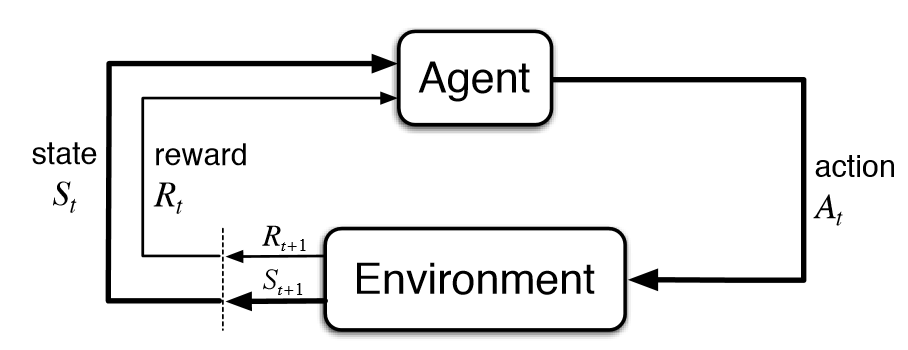

In [ ]:
LENGTH = 3


class Agent:
  def __init__(self, eps=0.1, alpha=0.5):
    self.eps = eps # probability of choosing random action instead of greedy
    self.alpha = alpha # learning rate
    self.verbose = False
    self.state_history = []

  def setV(self, V):
    self.V = V

  def set_symbol(self, sym):
    self.sym = sym

  def set_verbose(self, v):
    # if true, will print values for each position on the board
    self.verbose = v

  def reset_history(self):
    self.state_history = []

  def take_action(self, env):
    # choose an action based on epsilon-greedy strategy
    r = np.random.rand()
    best_state = None
    if r < self.eps:
      # take a random action
      if self.verbose:
        print("Taking a random action")

      possible_moves = []
      for i in range(LENGTH):
        for j in range(LENGTH):
          if env.is_empty(i, j):
            possible_moves.append((i, j))
      idx = np.random.choice(len(possible_moves))
      next_move = possible_moves[idx]
    else:
      # choose the best action based on current values of states
      # loop through all possible moves, get their values
      # keep track of the best value
      pos2value = {} # for debugging
      next_move = None
      best_value = -1
      for i in range(LENGTH):
        for j in range(LENGTH):
          if env.is_empty(i, j):
            # what is the state if we made this move?
            env.board[i,j] = self.sym
            state = env.get_state()
            env.board[i,j] = 0 # don't forget to change it back!
            pos2value[(i,j)] = self.V[state]
            if self.V[state] > best_value:
              best_value = self.V[state]
              best_state = state
              next_move = (i, j)

      # if verbose, draw the board w/ the values
      if self.verbose:
        print("Taking a greedy action")
        for i in range(LENGTH):
          print("------------------")
          for j in range(LENGTH):
            if env.is_empty(i, j):
              # print the value
              print(" %.2f|" % pos2value[(i,j)], end="")
            else:
              print("  ", end="")
              if env.board[i,j] == env.x:
                print("x  |", end="")
              elif env.board[i,j] == env.o:
                print("o  |", end="")
              else:
                print("   |", end="")
          print("")
        print("------------------")

    # make the move
    env.board[next_move[0], next_move[1]] = self.sym

  def update_state_history(self, s):
    # cannot put this in take_action, because take_action only happens
    # once every other iteration for each player
    # state history needs to be updated every iteration
    # s = env.get_state() # don't want to do this twice so pass it in
    self.state_history.append(s)

  def update(self, env):
    # we want to BACKTRACK over the states, so that:
    # V(prev_state) = V(prev_state) + alpha*(V(next_state) - V(prev_state))
    # where V(next_state) = reward if it's the most current state
    #
    # NOTE: we ONLY do this at the end of an episode
    # not so for all the algorithms we will study
    reward = env.reward(self.sym)
    target = reward
    for prev in reversed(self.state_history):
      value = self.V[prev] + self.alpha*(target - self.V[prev])
      self.V[prev] = value
      target = value
    self.reset_history()


# this class represents a tic-tac-toe game
# is a CS101-type of project
class Environment:
  def __init__(self):
    self.board = np.zeros((LENGTH, LENGTH))
    self.x = -1 # represents an x on the board, player 1
    self.o = 1 # represents an o on the board, player 2
    self.winner = None
    self.ended = False
    self.num_states = 3**(LENGTH*LENGTH)

  def is_empty(self, i, j):
    return self.board[i,j] == 0

  def reward(self, sym):
    # no reward until game is over
    if not self.game_over():
      return 0

    # if we get here, game is over
    # sym will be self.x or self.o
    return 1 if self.winner == sym else 0

  def get_state(self):
    # returns the current state, represented as an int
    # from 0...|S|-1, where S = set of all possible states
    # |S| = 3^(BOARD SIZE), since each cell can have 3 possible values - empty, x, o
    # some states are not possible, e.g. all cells are x, but we ignore that detail
    # this is like finding the integer represented by a base-3 number
    k = 0
    h = 0
    for i in range(LENGTH):
      for j in range(LENGTH):
        if self.board[i,j] == 0:
          v = 0
        elif self.board[i,j] == self.x:
          v = 1
        elif self.board[i,j] == self.o:
          v = 2
        h += (3**k) * v
        k += 1
    return h

  def game_over(self, force_recalculate=False):
    # returns true if game over (a player has won or it's a draw)
    # otherwise returns false
    # also sets 'winner' instance variable and 'ended' instance variable
    if not force_recalculate and self.ended:
      return self.ended

    # check rows
    for i in range(LENGTH):
      for player in (self.x, self.o):
        if self.board[i].sum() == player*LENGTH:
          self.winner = player
          self.ended = True
          return True

    # check columns
    for j in range(LENGTH):
      for player in (self.x, self.o):
        if self.board[:,j].sum() == player*LENGTH:
          self.winner = player
          self.ended = True
          return True

    # check diagonals
    for player in (self.x, self.o):
      # top-left -> bottom-right diagonal
      if self.board.trace() == player*LENGTH:
        self.winner = player
        self.ended = True
        return True
      # top-right -> bottom-left diagonal
      if np.fliplr(self.board).trace() == player*LENGTH:
        self.winner = player
        self.ended = True
        return True

    # check if draw
    if np.all((self.board == 0) == False):
      # winner stays None
      self.winner = None
      self.ended = True
      return True

    # game is not over
    self.winner = None
    return False

  def is_draw(self):
    return self.ended and self.winner is None

  # Example board
  # -------------
  # | x |   |   |
  # -------------
  # |   |   |   |
  # -------------
  # |   |   | o |
  # -------------
  def draw_board(self):
    for i in range(LENGTH):
      print("-------------")
      for j in range(LENGTH):
        print("  ", end="")
        if self.board[i,j] == self.x:
          print("x ", end="")
        elif self.board[i,j] == self.o:
          print("o ", end="")
        else:
          print("  ", end="")
      print("")
    print("-------------")



class Human:
  def __init__(self):
    pass

  def set_symbol(self, sym):
    self.sym = sym

  def take_action(self, env):
    while True:
      # break if we make a legal move
      move = input("Enter coordinates i,j for your next move (i,j=0..2): ")
      i, j = move.split(',')
      i = int(i)
      j = int(j)
      if env.is_empty(i, j):
        env.board[i,j] = self.sym
        break

  def update(self, env):
    pass

  def update_state_history(self, s):
    pass


# recursive function that will return all
# possible states (as ints) and who the corresponding winner is for those states (if any)
# (i, j) refers to the next cell on the board to permute (we need to try -1, 0, 1)
# impossible games are ignored, i.e. 3x's and 3o's in a row simultaneously
# since that will never happen in a real game
def get_state_hash_and_winner(env, i=0, j=0):
  results = []

  for v in (0, env.x, env.o):
    env.board[i,j] = v # if empty board it should already be 0
    if j == 2:
      # j goes back to 0, increase i, unless i = 2, then we are done
      if i == 2:
        # the board is full, collect results and return
        state = env.get_state()
        ended = env.game_over(force_recalculate=True)
        winner = env.winner
        results.append((state, winner, ended))
      else:
        results += get_state_hash_and_winner(env, i + 1, 0)
    else:
      # increment j, i stays the same
      results += get_state_hash_and_winner(env, i, j + 1)

  return results

# play all possible games
# need to also store if game is over or not
# because we are going to initialize those values to 0.5
# NOTE: THIS IS SLOW because MANY possible games lead to the same outcome / state
# def get_state_hash_and_winner(env, turn='x'):
#   results = []

#   state = env.get_state()
#   # board_before = env.board.copy()
#   ended = env.game_over(force_recalculate=True)
#   winner = env.winner
#   results.append((state, winner, ended))

#   # DEBUG
#   # if ended:
#   #   if winner is not None and env.win_type.startswith('col'):
#   #     env.draw_board()
#   #     print "Winner:", 'x' if winner == -1 else 'o', env.win_type
#   #     print "\n\n"
#   #     assert(np.all(board_before == env.board))

#   if not ended:
#     if turn == 'x':
#       sym = env.x
#       next_sym = 'o'
#     else:
#       sym = env.o
#       next_sym = 'x'

#     for i in xrange(LENGTH):
#       for j in xrange(LENGTH):
#         if env.is_empty(i, j):
#           env.board[i,j] = sym
#           results += get_state_hash_and_winner(env, next_sym)
#           env.board[i,j] = 0 # reset it
#   return results


def initialV_x(env, state_winner_triples):
  # initialize state values as follows
  # if x wins, V(s) = 1
  # if x loses or draw, V(s) = 0
  # otherwise, V(s) = 0.5
  V = np.zeros(env.num_states)
  for state, winner, ended in state_winner_triples:
    if ended:
      if winner == env.x:
        v = 1
      else:
        v = 0
    else:
      v = 0.5
    V[state] = v
  return V


def initialV_o(env, state_winner_triples):
  # this is (almost) the opposite of initial V for player x
  # since everywhere where x wins (1), o loses (0)
  # but a draw is still 0 for o
  V = np.zeros(env.num_states)
  for state, winner, ended in state_winner_triples:
    if ended:
      if winner == env.o:
        v = 1
      else:
        v = 0
    else:
      v = 0.5
    V[state] = v
  return V


def play_game(p1, p2, env, draw=False):
  # loops until the game is over
  current_player = None
  while not env.game_over():
    # alternate between players
    # p1 always starts first
    if current_player == p1:
      current_player = p2
    else:
      current_player = p1

    # draw the board before the user who wants to see it makes a move
    if draw:
      if draw == 1 and current_player == p1:
        env.draw_board()
      if draw == 2 and current_player == p2:
        env.draw_board()

    # current player makes a move
    current_player.take_action(env)

    # update state histories
    state = env.get_state()
    p1.update_state_history(state)
    p2.update_state_history(state)

  if draw:
    env.draw_board()

  # do the value function update
  p1.update(env)
  p2.update(env)

In [ ]:
# train the agent
p1 = Agent()
p2 = Agent()

# set initial V for p1 and p2
env = Environment()
state_winner_triples = get_state_hash_and_winner(env)


Vx = initialV_x(env, state_winner_triples)
p1.setV(Vx)
Vo = initialV_o(env, state_winner_triples)
p2.setV(Vo)

# give each player their symbol
p1.set_symbol(env.x)
p2.set_symbol(env.o)

T = 10000
for t in range(T):
  if t % 1000 == 0:
    print(t)
  play_game(p1, p2, Environment())

# play human vs. agent
# do you think the agent learned to play the game well?
human = Human()
human.set_symbol(env.o)
while True:
  p1.set_verbose(True)
  play_game(p1, human, Environment(), draw=2)
  # I made the agent player 1 because I wanted to see if it would
  # select the center as its starting move. If you want the agent
  # to go second you can switch the human and AI.
  answer = input("Play again? [Y/n]: ")
  if answer and answer.lower()[0] == 'n':
    break

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Taking a greedy action
------------------
 0.50| 0.75| 0.57|
------------------
 0.51| 0.95| 0.51|
------------------
 0.46| 0.49| 0.68|
------------------
-------------
            
-------------
      x     
-------------
            
-------------
Enter coordinates i,j for your next move (i,j=0..2): 0,1
Taking a greedy action
------------------
 1.00|  o  | 0.73|
------------------
 0.88|  x  | 0.72|
------------------
 0.76| 0.03| 0.90|
------------------
-------------
  x   o     
-------------
      x     
-------------
            
-------------
Enter coordinates i,j for your next move (i,j=0..2): 2,2
Taking a greedy action
------------------
  x  |  o  | 0.06|
------------------
 0.82|  x  | 0.87|
------------------
 1.00| 0.62|  o  |
------------------
-------------
  x   o     
-------------
      x     
-------------
  x       o 
-------------


KeyboardInterrupt: Interrupted by user